## Analyze domain surface stickiness
This notebook analyzes how surface-residue stickiness correlates with solublity quantile. Stickiness here is as the residue-intrinsic "stickiness" parameter as defined by Dubreuil et al. (Table S1) [1].


### References
[1] Dubreuil, B., Matalon, O. & Levy, E. D. Protein abundance biases the amino acid composition of disordered regions to minimize non-functional interactions. J. Mol. Biol. 431, 4978–4992 (2019).
  


In [12]:
import numpy as np
import matplotlib
import os
import sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from shephard.apis.fasta import fasta_to_proteome
from shephard import interfaces
from shephard.tools import attribute_tools

from sparrow import Protein

from shephard import Proteome


from sparrow.data.amino_acids import VALID_AMINO_ACIDS

# lets you import from the code directory here
local_code_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'code'))

if local_code_path not in sys.path:
    sys.path.append(local_code_path)

from common_functions import annotate_with_quantiles

def normalize_array(arr):
    """
    Local function that takes in a list of array and normalizes
    it so it's rescaled to run between 0 and 1 regardless of what
    the actual values .

    Parameters
    
    """
    min_val = np.min(arr)
    max_val = np.max(arr)
    normalized_arr = (arr - min_val) / (max_val - min_val)
    return normalized_arr
    

In [13]:
# define per-residue Stickiness as reported by Dubreuil et al
STICKINESS = {
    "A": 0.0062,
    "C": 1.0372,
    "D": -0.7485,
    "E": -0.7893,
    "F": 1.2727,
    "G": -0.1771,
    "H": 0.1204,
    "I": 1.1109,
    "K": -1.1806,
    "L": 0.9138,
    "M": 1.0124,
    "N": -0.2693,
    "P": -0.1799,
    "Q": -0.4114,
    "R": -0.0876,
    "S": 0.1376,
    "T": 0.1031,
    "V": 0.7599,
    "W": 0.7925,
    "Y": 0.8806}

def domain_stickiness(domain_obj):
    summed_stickiness = 0
    count = 0
    for AA in VALID_AMINO_ACIDS:
        s = f'{AA}_SASA_count'
        if s in d.attributes:
            summed_stickiness = summed_stickiness + d.attribute(s)*STICKINESS[AA]
            count = count + d.attribute(s)
    return (summed_stickiness, summed_stickiness/count)
    
            
    

# Defining settings
The cell below defines the setting this notebook will be using. In principle you should not need to change any other settings...

In [14]:

# defines how we're defining our folded domains. option
domain_def = 'chainsaw'

# mode is a variable we can tweak 
mode = '_count'


# smallest domain we'll consider
min_size_threshold = 90

# largest domain we'll consider
max_size_threshold = 1000

# threshold for SASA - domains where fraction of residues on surface ABOVE this threshold 
# are discarded
max_sasa_threshold = 1.0

# SASA mode (can only be v1)
sasa_mode = 'v1'

# SASA sensitivity factor (10 or 40 - this is precomputed, but 10 is more permisive than 40)
sasa_sensitivity_factor = 40

## Sanity check your settings, yo!
if domain_def not in ['chainsaw', 'dodo']:
    raise Exception('Invalid mode: must be "chainsaw" or "dodo"')

if mode not in ['_count', '']:
    raise Exception('Invalid mode: must be "_count" or ""')
    
if mode == '_count':
    mode_name = 'rescount'    
else:
    raise Exception('Using anything except rescount does not make sense here')

## NB: STRONGLY suggest stick with the default parameters because the stickiness index accounts for SASA; the code will 
# throw and exception if you try and use SASA mode...


## Load proteome, annotate, and cast attributes
The code below does all the attribute casting to prepare the annotated proteomes

In [15]:
# load in the proteome object
yp = Proteome()
interfaces.si_proteins.add_proteins_from_file(yp,'../data/experimental_data/shprd_proteome_soluble_only_v2.tsv')

# define the string identty of the SASA attribute annotation
data_string = f'shprd_{domain_def}_domain_sasa_{sasa_mode}_{sasa_sensitivity_factor}.tsv'
print(f"Using {data_string}")

# annotate the proteome with those SASA attributes
interfaces.si_domains.add_domains_from_file(yp,f'../data/shprd_files/{data_string}')

# cast all values to float 
for d in yp.domains:
    attribute_tools.cast_attributes(d)

# cast protein numerical values; note we don't actually use most
# of these in this notebook, but we do this anyway for completeness
# NOTE this requires the most modern version of SHEPHARD on GitHub...
for p in yp:
    attribute_tools.cast_attributes(p,exclude=['lip_color', 'non_ref_score', 'refoldable', 'nonrefoldable', 'membrane_protein','non_ref','subcellular_localization'])

# precompute some sanity stuff
total_dodo_domains_soluble = len(yp.domains)
total_dodo_domains_within_size_thresh = 0
total_dodo_domains_within_size_thresh_and_sasa_thresh = 0

for d in yp.domains:
    if (len(d) < min_size_threshold or len(d) > max_size_threshold):
        pass
    else:
        total_dodo_domains_within_size_thresh = total_dodo_domains_within_size_thresh + 1


for d in yp.domains:
    if (len(d) < min_size_threshold or len(d) > max_size_threshold) or d.attribute('fraction_sasa') > max_sasa_threshold:
        pass
    else:
        total_dodo_domains_within_size_thresh_and_sasa_thresh = total_dodo_domains_within_size_thresh_and_sasa_thresh + 1

print(f"Total {domain_def} domains in soluble proteins: {total_dodo_domains_soluble}")
print(f"Total {domain_def} domains in soluble proteins within size threshold: {total_dodo_domains_within_size_thresh}")
print(f"Total {domain_def} domains in soluble proteins within size threshold and after SASA filtering: {total_dodo_domains_within_size_thresh_and_sasa_thresh}")

Using shprd_chainsaw_domain_sasa_v1_40.tsv
Total chainsaw domains in soluble proteins: 8199
Total chainsaw domains in soluble proteins within size threshold: 5477
Total chainsaw domains in soluble proteins within size threshold and after SASA filtering: 5477


# Filter by SASA or total SASA_fraction
We remove domains smaller than 90 and above 1000 for the analysis. We then assign quantiles to each protein based on the S/T score

In [16]:
print(f'\n[STATUS]: Filtering out proteins smaller than {min_size_threshold}, larger than {max_size_threshold} or with a total SASA fraction above {max_sasa_threshold}')

# just for sanity checking we build a list of all the domain lengths
# BEFORE we filter out those that are too long or too short...
domain_lengths_before_filter = []
for d in yp.domains:
    domain_lengths_before_filter.append(len(d))


# Next we filter out domanis that are:
# 1. To small
# 2. To bigg
# 3. Have too many solvent exposed residues (i.e. there's no longer an interior that makes sense to talk about the 'surface')

domains_to_remove = []
for d in yp.domains:
    if (len(d) < min_size_threshold or len(d) > max_size_threshold) or d.attribute('fraction_sasa') > max_sasa_threshold:
        domains_to_remove.append(d)
    
# actually remove the domains from the proteome
for d in domains_to_remove:
    p = yp.protein(d.protein.unique_ID)
    p.remove_domain(d)

after_filtering_count = len(yp.domains)


print("[STATUS]: Annotating proteins with quantiles, only annotating proteins with one or more domain\n")
# annotate each remaining protein with a 8 quantiles where we ONLY consider proteins that have
# domains in the list from which quantiles are determined
annotate_with_quantiles(yp,q=8,proteins_with_domains=True)    


after_filtering_count_with_exp_data = 0
for p in yp:
    if 'quantile' in p.attributes:
        after_filtering_count_with_exp_data = after_filtering_count_with_exp_data + len(p.domains)
        

print('------------')
print(f"[STATUS]: Filtering removed {len(domain_lengths_before_filter) - after_filtering_count} domains")
print(f"[STATUS]: Left with {after_filtering_count} domains BEFORE filtering for experimental data")
print(f"[STATUS]: Left with {after_filtering_count_with_exp_data} domains AFTER filtering for data")

c=0
for p in yp:
    if len(p.domains) > 0:
        c = c + 1    
print(f"[STATUS]: Number of proteins with one or more domain {c}")

    
QUANTILE_REF = [6, 18, 30, 42, 54, 66, 78, 90]


[STATUS]: Filtering out proteins smaller than 90, larger than 1000 or with a total SASA fraction above 1.0
[STATUS]: Annotating proteins with quantiles, only annotating proteins with one or more domain

Sanity check number of proteins in each group
[361, 361, 361, 361, 360, 360, 360, 360]
------------
[STATUS]: Filtering removed 2722 domains
[STATUS]: Left with 5477 domains BEFORE filtering for experimental data
[STATUS]: Left with 5477 domains AFTER filtering for data
[STATUS]: Number of proteins with one or more domain 2884


### Establish how SASA accessible these domains are
The first thing we do is cycle over each domain and, for each domain, extract out the domain length and the fraction of residues that are solvent accessible. We then save the scatter plot of SASA fraction vs. domain length. This is primarily a sanity check but also lets us know exactly what the data we're looking at looks like..

In [17]:
## BIG LOOP GO FAST

quantile_to_summed_stickiness = {}
quantile_to_mean_stickiness = {}

# for each protein
for p in yp:
    
    # if that protein was annotated with a quantile then...
    if 'quantile' in p.attributes:

        # initialize if needed
        if p.attribute('quantile') not in quantile_to_summed_stickiness:
            quantile_to_summed_stickiness[p.attribute('quantile')] = []
            quantile_to_mean_stickiness[p.attribute('quantile')] = []

        for d in p.domains:
            sout = domain_stickiness(d)
            quantile_to_summed_stickiness[p.attribute('quantile')].append(sout[0])
            quantile_to_mean_stickiness[p.attribute('quantile')].append(sout[1])
            

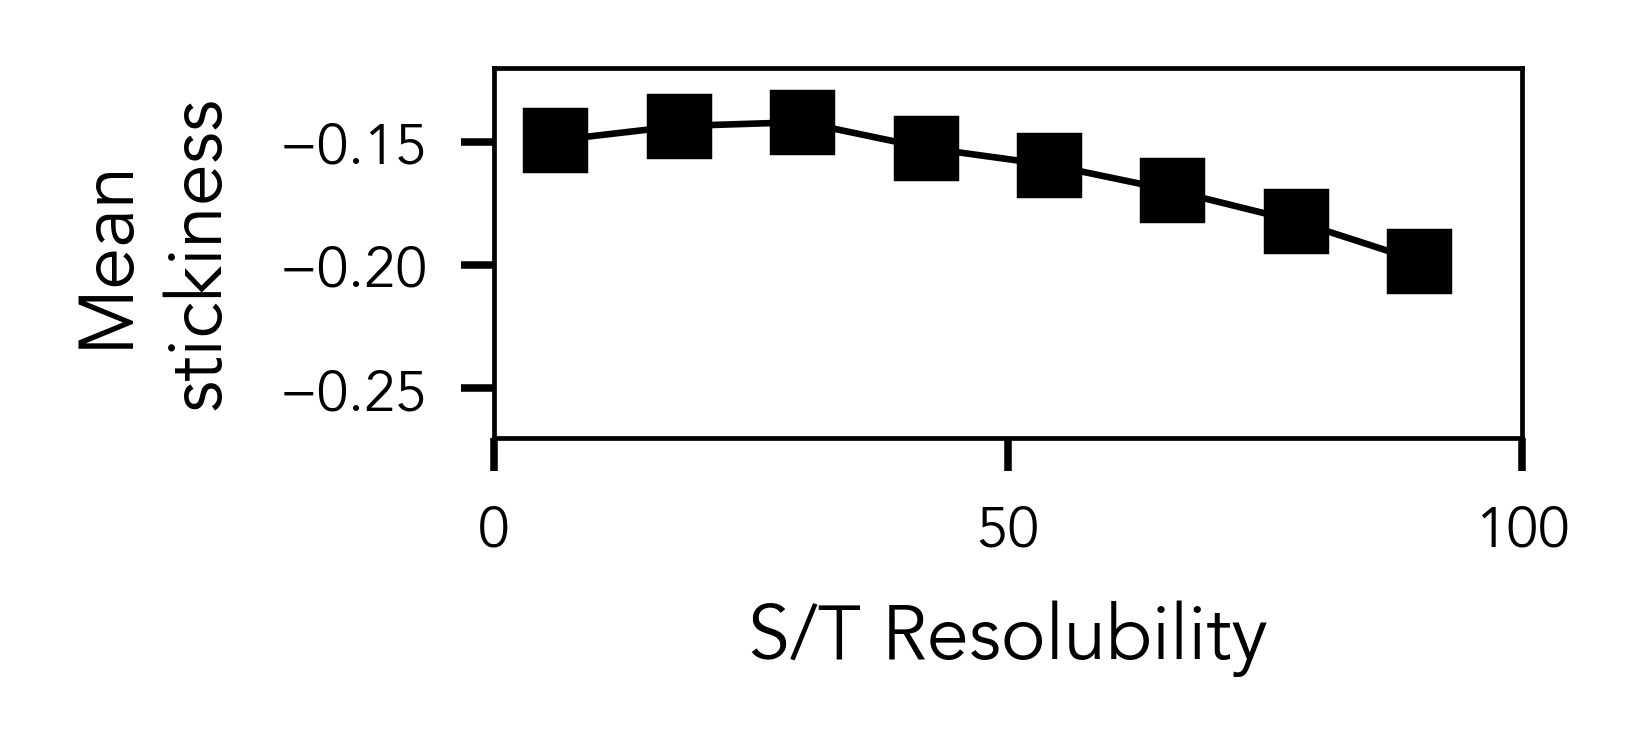

In [18]:
figure(None, (2.5,1.2), dpi=340)

tmp = [np.mean(quantile_to_mean_stickiness[q]) for q in QUANTILE_REF]
plt.plot(QUANTILE_REF, tmp, '-sk', lw=0.7)
plt.ylim([-0.27,-0.12])
plt.xlim([0,100])
plt.xlabel('S/T Resolubility',fontsize=8)
plt.ylabel('Mean\nstickiness',fontsize=8)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.savefig(f'outfigures_surface_chemistry/{domain_def}/quantile_vs_stickiness.pdf')

